# Import Libraries

In [1]:
# Librerías estándar
import os
import random
import warnings
import glob as gb

# Manipulación de datos
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
%matplotlib inline

# Procesamiento de imágenes
import cv2

# TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input

# Keras (Si ya usas TensorFlow Keras, estos podrían no ser necesarios)
from keras.models import Sequential

# Conexión a Google Colab
from google.colab import drive

# Scikit-learn para modelado y evaluación
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report, accuracy_score

# Preparing data

Excluimos las carpetas que no son de utilidad para el desarrollo del problema

In [2]:
excluded_folders = ["bornite", "muscovite", ".ipynb_checkpoints", "Minerals_5640.csv"]

In [3]:
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [4]:
data = '/content/drive/My Drive/Minet 5640 Images/'
#data = 'Minet 5640 Images/'

Podemos ver la cantidad de imágenes que hay en cada dataset y vemos que las clases estan desbalanceadas, especialmente chrysocolla por lo que pasamos a balancearlas.

For data, found 1155 in folder quartz
For data, found 1025 in folder biotite
For data, found 1057 in folder pyrite
For data, found 525 in folder chrysocolla
For data, found 975 in folder malachite


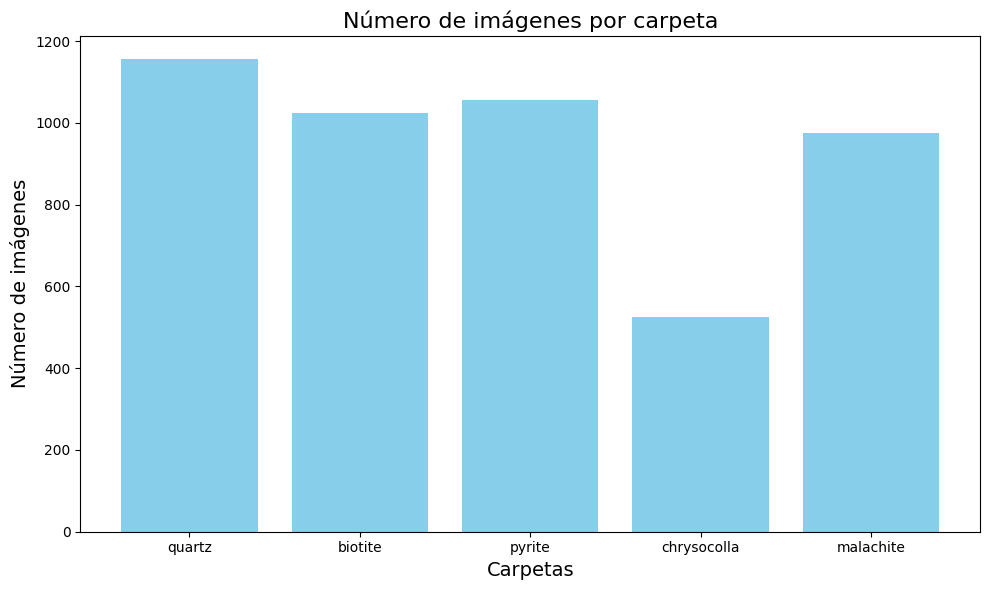

In [5]:
image_count_per_folder = {}

# Reemplaza 'data' y 'excluded_folders' con los valores apropiados
for folder in os.listdir(data):
    if folder not in excluded_folders:
        files = gb.glob(pathname=str(data + folder + '/*.jpg'))
        image_count_per_folder[folder] = len(files)  # Guardar el conteo de archivos
        print(f'For data, found {len(files)} in folder {folder}')

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(image_count_per_folder.keys(), image_count_per_folder.values(), color='skyblue')

# Añadir títulos y etiquetas
plt.title('Número de imágenes por carpeta', fontsize=16)
plt.xlabel('Carpetas', fontsize=14)
plt.ylabel('Número de imágenes', fontsize=14)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Podemos ver algunas de las iamgenes que conforman el dataset en cada una de las clases.

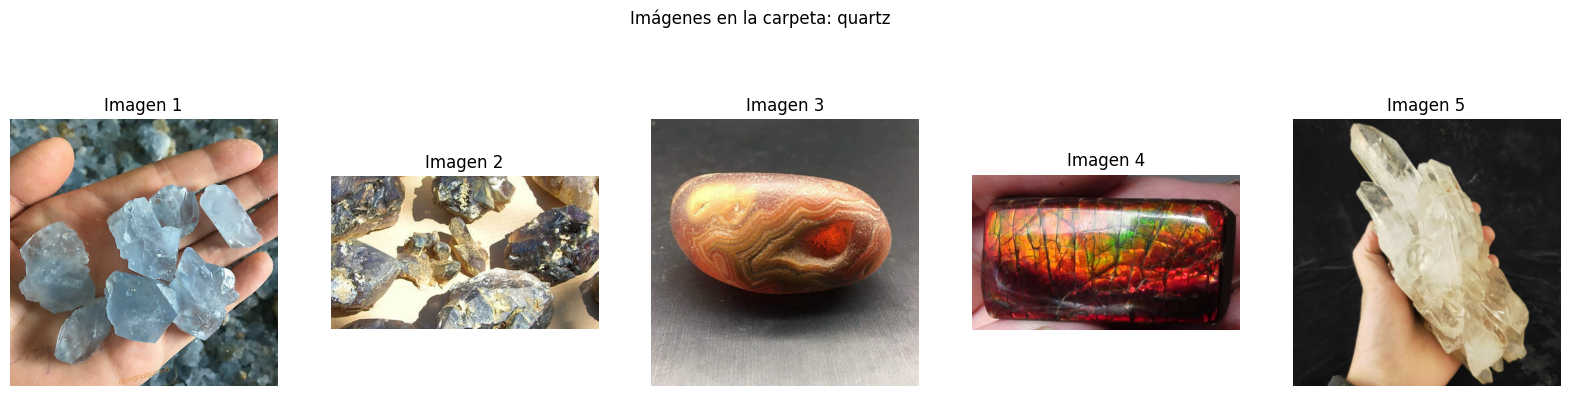

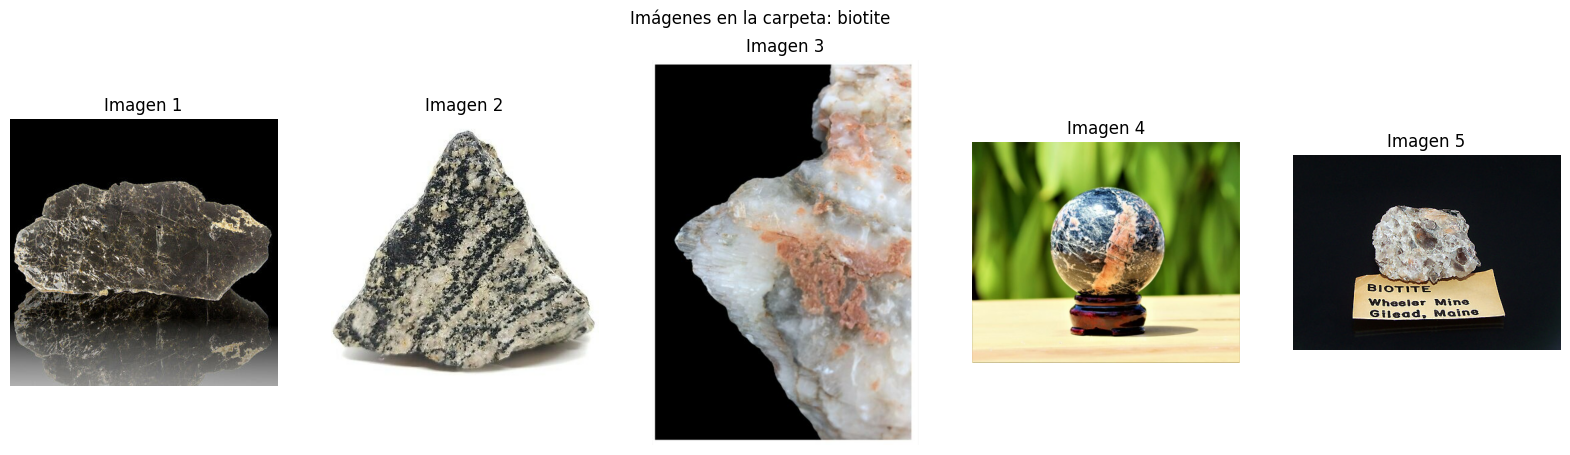

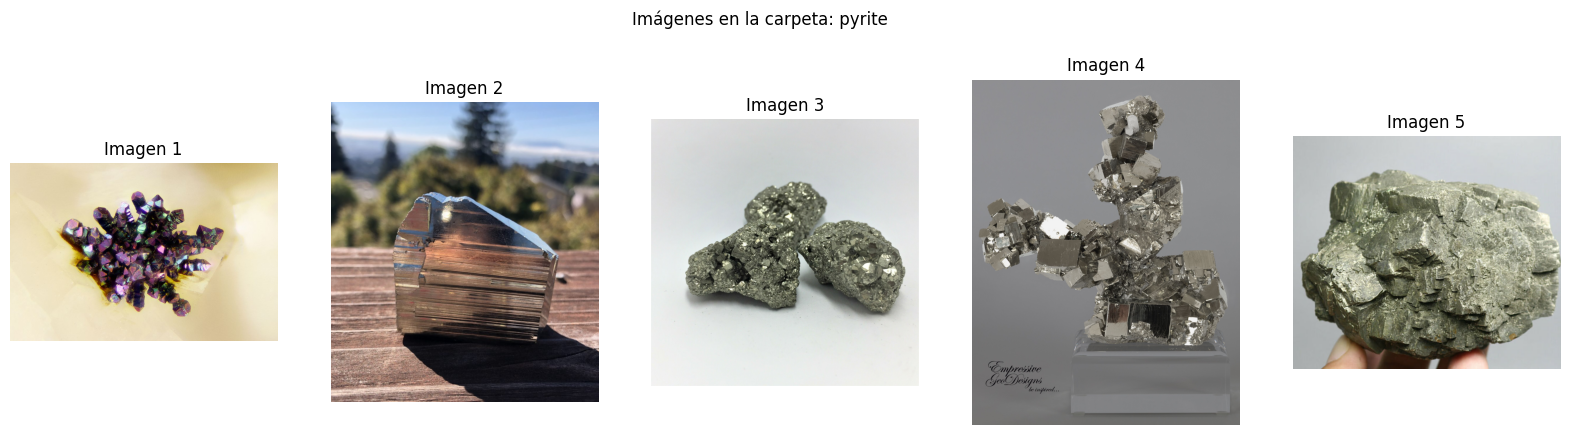

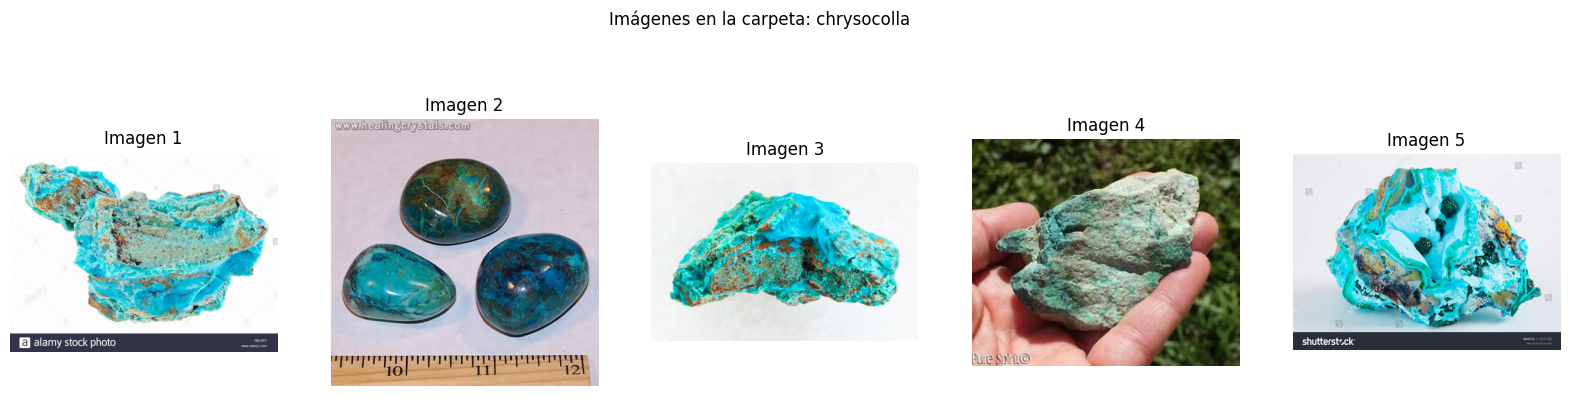

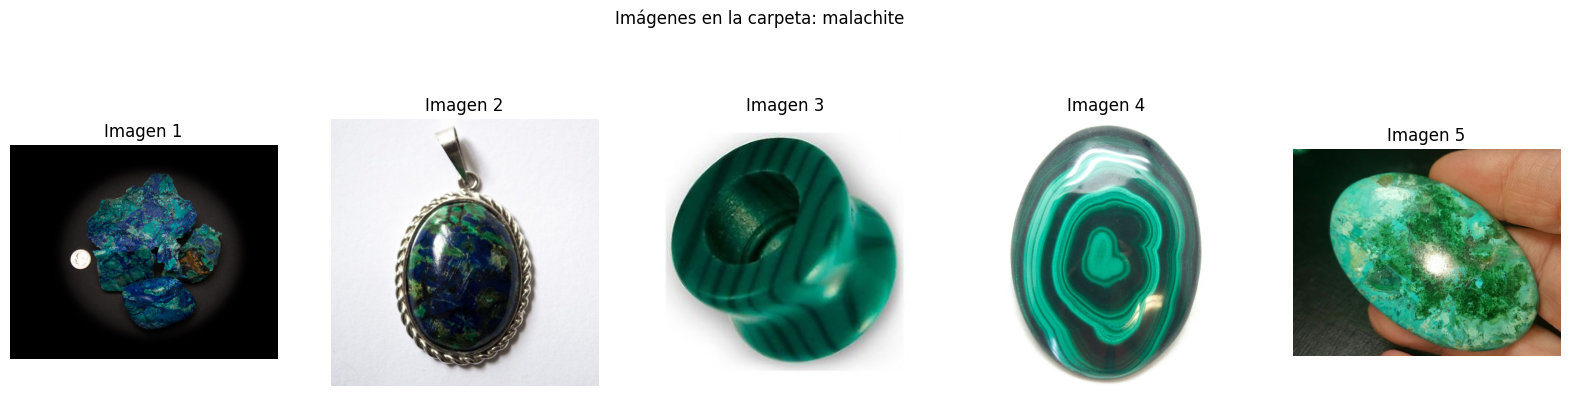

In [6]:
for folder in os.listdir(data):
    if folder not in excluded_folders:
        folder_path = os.path.join(data, folder)
        files = gb.glob(os.path.join(folder_path, "*.jpg"))

        plt.figure(figsize=(20, 5))  # Ajustar el tamaño de la figura
        for i, file in enumerate(files[:5]):  # Limitar a las 5 primeras imágenes
            img = mpimg.imread(file)
            plt.subplot(1, 5, i+1)  # Crear un subplot para cada imagen
            plt.imshow(img)
            plt.axis('off')  # Ocultar los ejes
            plt.title(f"Imagen {i+1}")

        plt.suptitle(f"Imágenes en la carpeta: {folder}")
        plt.show()

Función para facilitar acceder al nombre de cada carpeta

In [7]:
code = {'biotite':0 ,'bornite':1 ,'chrysocolla':2,'malachite':3, 'muscovite':4, 'pyrite':5, 'quartz':6}
def getcode(n) :
    for x , y in code.items() :
        if n == y :
            return x

Verificamos los tamaños de algunas imágenes que conforman el dataset

In [8]:
size = []
for folder in  os.listdir(data) :
  if folder not in excluded_folders:
    files = gb.glob(pathname= str( data + folder + '/*.jpg'))
    for file in files:
        image = plt.imread(file)
        size.append(image.shape)
pd.Series(size).value_counts

<bound method IndexOpsMixin.value_counts of 0         (400, 400, 3)
1         (500, 877, 3)
2       (1000, 1000, 3)
3        (766, 1315, 3)
4         (640, 640, 3)
             ...       
4732     (768, 1024, 3)
4733      (640, 640, 3)
4734     (664, 1000, 3)
4735      (454, 652, 3)
4736     (680, 1024, 3)
Length: 4737, dtype: object>

In [9]:
size[1:5]

[(500, 877, 3), (1000, 1000, 3), (766, 1315, 3), (640, 640, 3)]

Balanceamos las clases utilizando transformaciones sobre la orientación de la imagen y dejamos todas las imágenes del mismo tamaño.

También utilizamos el label encoder que posteriormente nos permitirá acceder al nombre de cada una de las clases y hacer los gráficos más interpretables.

Al final podemos ver un gráfico con las clases balanceadas

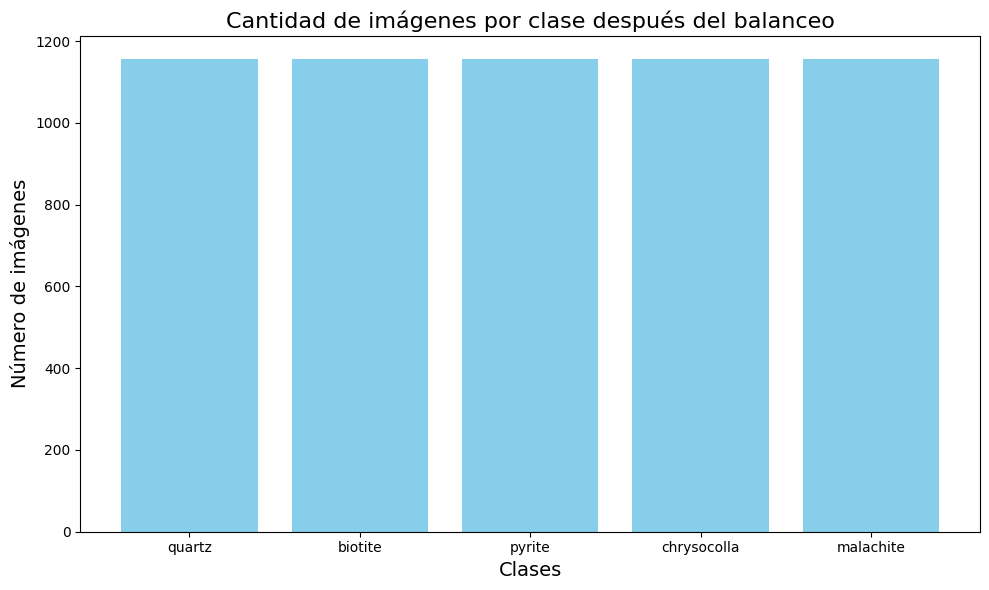

Orden de las clases: ['biotite' 'chrysocolla' 'malachite' 'pyrite' 'quartz']


In [10]:
s = 224  # Tamaño objetivo de las imágenes
target_size = (s, s)  # Tamaño para el redimensionado
X_Images = []
y_Types = []
folders = []  # Almacenar nombres de carpetas (clases)
image_count_per_class = {}

# Cargar imágenes y realizar aumentación si es necesario
for folder in os.listdir(data):
    if folder not in excluded_folders:
        files = gb.glob(pathname=str(data + folder + '/*.jpg'))
        image_count_per_class[folder] = len(files)

        # Listas temporales para las imágenes y etiquetas de la clase actual
        class_images = []
        class_labels = []

        # Cargar y procesar las imágenes originales
        for file in files:
            image = cv2.imread(file)
            info = np.iinfo(image.dtype)  # Obtener información del tipo de la imagen
            image = image.astype(np.float64) / info.max
            image = 255 * image
            image = image.astype(np.uint8)  # Convertir a uint8
            image_array = cv2.resize(image, target_size)  # Redimensionar la imagen
            class_images.append(image_array)  # Agregar imagen procesada a la lista de la clase
            class_labels.append(folder)  # Guardar el nombre de la carpeta como clase

        # Realizar aumentación si es necesario
        num_images = len(class_images)
        if num_images < 1155:
            num_augmented = 1155 - num_images
            for _ in range(num_augmented):
                idx = random.randint(0, num_images - 1)
                image_to_augment = class_images[idx]

                # Aumentación: flip horizontal
                augmented_image = cv2.flip(image_to_augment, 1)
                class_images.append(augmented_image)
                class_labels.append(folder)

        # Actualizar el conteo de imágenes por clase
        image_count_per_class[folder] = len(class_images)

        # Agregar las imágenes y etiquetas de la clase actual a las listas principales
        X_Images.extend(class_images)
        folders.extend(class_labels)

# Codificar las clases usando LabelEncoder
le = LabelEncoder()
y_Types = le.fit_transform(folders)  # Convierte nombres de carpetas a etiquetas numéricas
class_names = le.classes_  # Almacena los nombres de las clases en el orden correcto

# Generar gráfico de barras para mostrar el tamaño de cada clase después del balanceo
plt.figure(figsize=(10, 6))
plt.bar(image_count_per_class.keys(), image_count_per_class.values(), color='skyblue')

# Añadir títulos y etiquetas
plt.title('Cantidad de imágenes por clase después del balanceo', fontsize=16)
plt.xlabel('Clases', fontsize=14)
plt.ylabel('Número de imágenes', fontsize=14)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Para saber el orden correcto de las clases en la matriz de confusión
print("Orden de las clases:", class_names)

Vemos la cantidad de imágenes con las que terminamos después de balancear.

In [11]:
print(f'Tenemos {len(X_Images)} imagenes en X_Images')

Tenemos 5775 imagenes en X_Images


Vemos el resultado de algunas imágenes despues del resize que hicimos anteriormente.

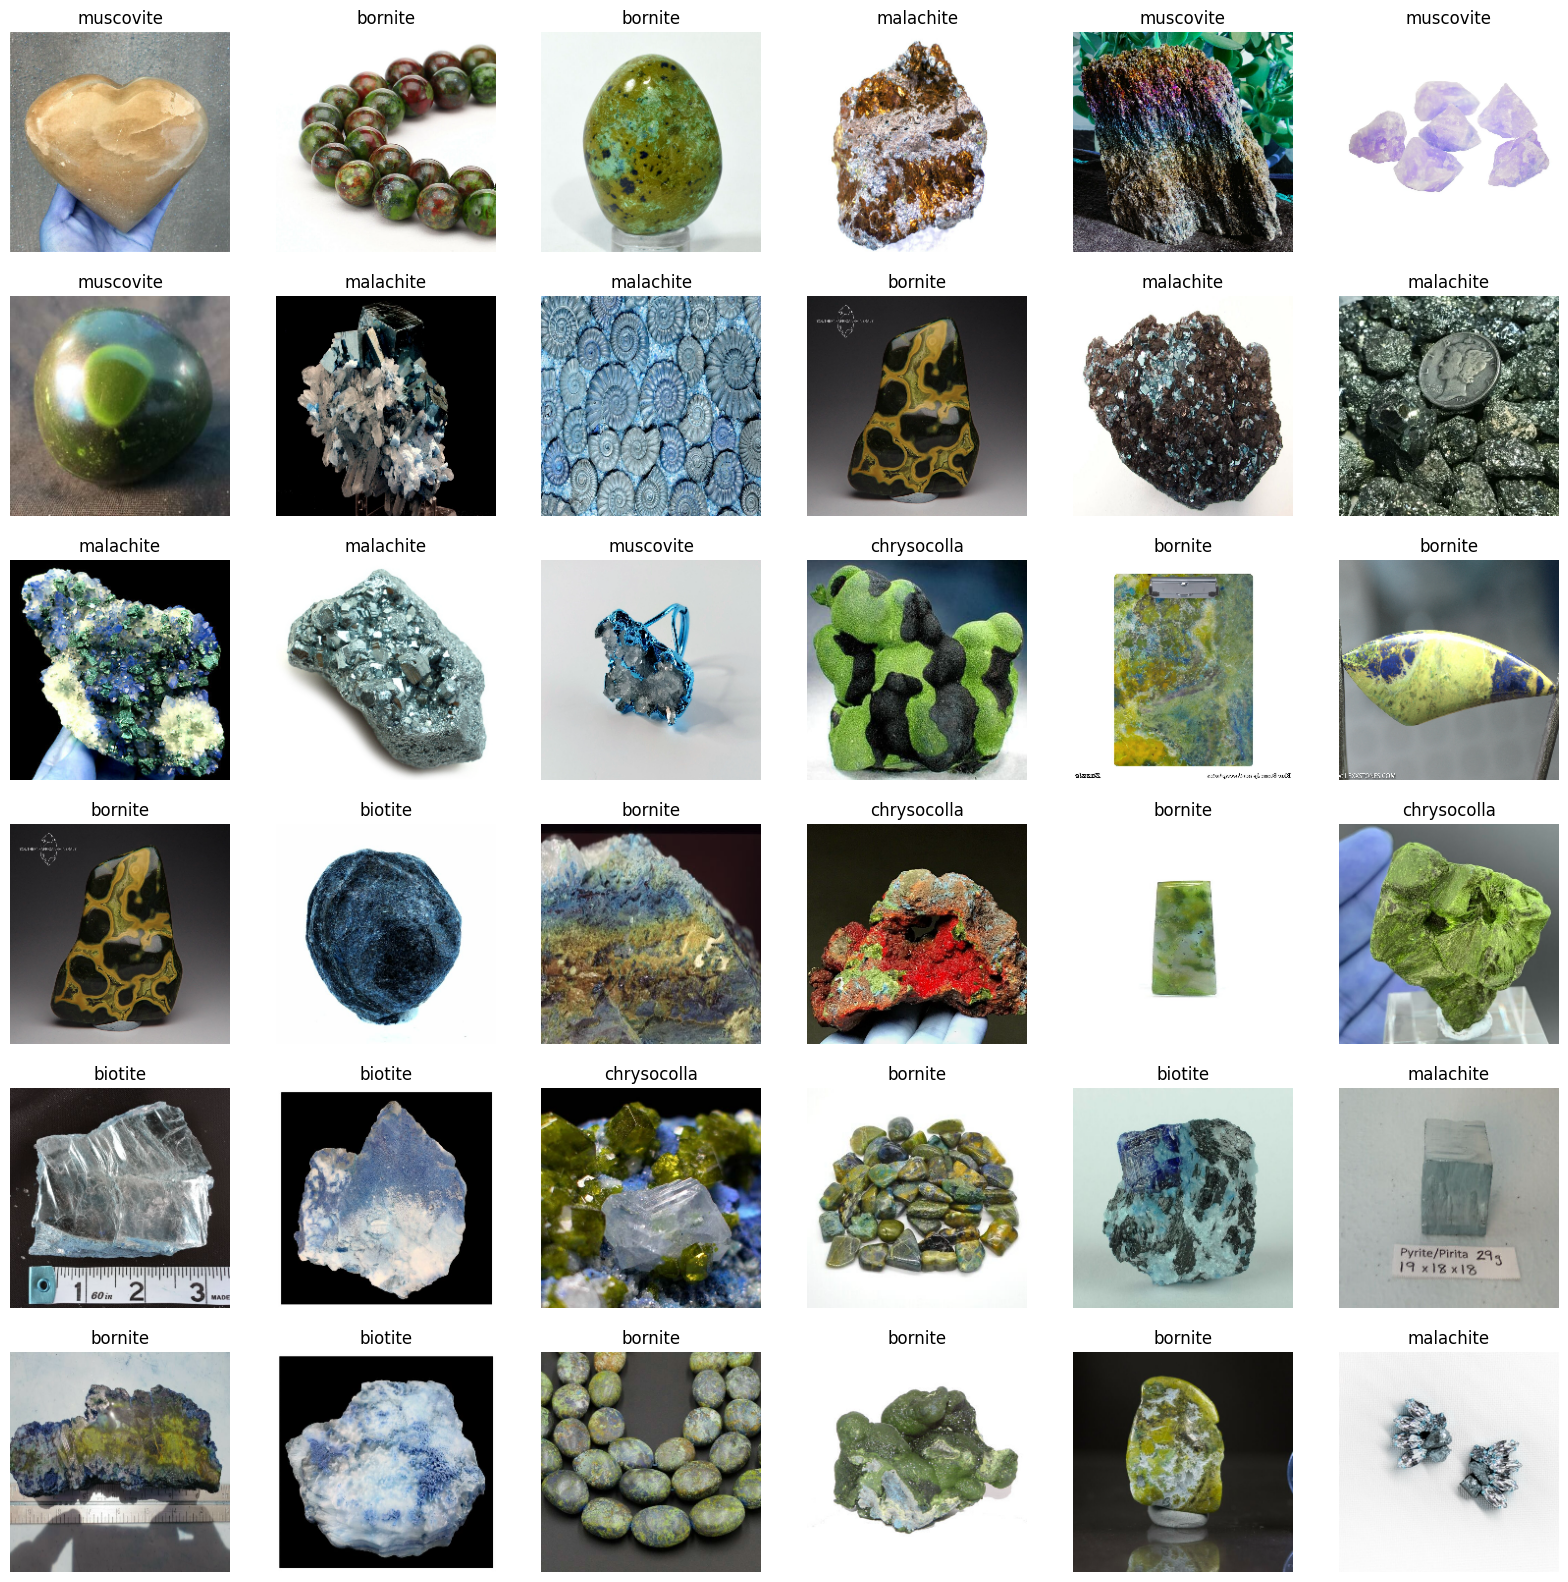

In [12]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_Images),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(X_Images[i])
    plt.axis('off')
    plt.title(getcode(y_Types[i]))

# Spliting data

Dividimos en conjunto de entrenamiento, validación y test, el cual nos pemitirá entrenar la red, que esta ajuste los hiperparámetros y poder evaluar su rendimiento.

Para el entrenamiento dejamos el 70%, del 30% restante dividimos la mitad para validación y la mitad para test.

In [13]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X_Images, y_Types, train_size=0.7,
                                                    shuffle=True, random_state=100)

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, train_size=0.5,
                                                    shuffle=True, random_state=100)

Convertimos todo a un array de numpy para poder pasarlo a la red neuronal.

In [14]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

La arquitectura que definimos para la red neuronal es la siguiente:

**Capa de entrada**

- Layer de Convolución con 32 filtros, lo cual nos permite extraer patrones sobre las imágenes, especialmente en cuanto a bordes o texturas, utiliza la función de activación relu.

**Segunda capa**

- Layer de Convolución con 64 filtros lo cual esta pensado para poder aprender características más complejas que en la capa anterior, usa la misma función de activación relu.
- Layer de Pooling: Utilizamos una capa de Pooling para que nos ayude a controlar el sobre ajuste reduciendo el tamaño de la imagen.

**Tercera capa**

- Layer de Convolución con 128 filtros lo cual esta pensado para poder aprender características más complejas que en la capa anterior, usa la misma función de activación relu.


**Capa de aplanamiento**

-Flatten aplana los tensores tridimensionales resultantes de las capas convolucionales anteriores en un vector unidimensional, que luego se conecta a las capas densas.

**Capa completamente conectada**
- Dense aplica 128 neuronas totalmente conectadas utilizando la función de activación relu, aprendiendo combinaciones de las características extraídas.
- Dropout aplica dropout para evitar el sobreajuste, haciendo que cada neurona tenga una probabilidad del 50% de ser apagada durante el entrenamiento.

In [15]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Regularización para evitar sobreajuste
    layers.Dense(len(np.unique(y_train)), activation='softmax')  # Para clasificación multiclase
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Podemos ver que el modelo resultante tiene la siguiente cantidad de parámetros **11,169,605 parámetros entrenables**. Contiene las capas explicadas anteriormente:
- Tres capas convolucionales (`conv2d`) seguidas de capas de agrupación máxima (`max_pooling2d`).
- Una capa de aplanamiento (`flatten`) para transformar la salida 3D en un vector 1D.
- Una capa densa de 128 neuronas.
- Una capa de *dropout* con una tasa de apagado de neuronas.
- Finalmente, una capa de salida densa con 5 neuronas (probablemente para clasificación en 5 clases).


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

### Callbacks utilizados en el entrenamiento:

1. **ReduceLROnPlateau**:
   - **Función**: Reduce la tasa de aprendizaje cuando la métrica monitoreada, en este caso `val_loss`, deja de mejorar.
   - **Parámetros clave**:
     - `factor`: Reduce la tasa de aprendizaje multiplicándola por este factor (0.2).
     - `patience`: Espera 5 épocas sin mejora antes de reducir la tasa de aprendizaje.
     - `min_lr`: Establece un límite inferior para la tasa de aprendizaje (1e-5).

2. **EarlyStopping**:
   - **Función**: Detiene el entrenamiento cuando la métrica monitoreada, `val_loss`, no mejora después de un número específico de épocas.
   - **Parámetros clave**:
     - `patience`: Detiene el entrenamiento si no hay mejora en 10 épocas.
     - `restore_best_weights`: Restaura los mejores pesos del modelo cuando se detiene el entrenamiento.

3. **ModelCheckpoint**:
   - **Función**: Guarda el modelo en cada época durante el entrenamiento, creando un archivo de punto de control para cada iteración.
   - **Parámetros clave**:
     - `filepath`: La ruta del archivo donde se guarda el modelo, incluyendo el número de la época.
     - `verbose`: Muestra un mensaje en la consola cuando el modelo se guarda.

In [17]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', # Métrica a monitorear
    factor = 0.2 , # Factor con el que se va a reducir la tasa de aprendizaje
    patience = 5 , # Reducir la tasa de aprendizaje después de cierta cantidad
                   # de épocas sin mejoramiento del modelo
    min_lr = 1e-5 ) # Límite inferior de la tasa de aprendizaje

early_stop = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', # Métrica a monitorear
    patience = 10,
    restore_best_weights = True
                    # cantidad de épocas sin mejoramiento del modelo
)

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint_epoch_{epoch:02d}.keras',  # Ruta del archivo para cada época
    verbose=1
)

Utilizamos como optimizador el algoritmo adam el cual tiene la ventaja de ser robusto y eficiente en términos de tiempo de cómputo, este se encarga de ajustar los pesos de la red para minimizar la función de pérdida, mejorando la capacidad del modelo para hacer predicciones correctas.

Definimos como función de pérdida a cross entrpy la cual es la que el modelo trata de minimizar durante el entrenamiento. La pérdida mide cuán bien o mal está funcionando el modelo, este compara las predicciones del modelo con las etiquetas verdaderas y calcula el error o discrepancia para ajustarse durante el entrenamiento.

Entrenaremos el modelo utilizando 50 epochs o hasta que el EarlyStopping lo permita.

In [18]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks = [reduce_lr , early_stop, checkpoint])

Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3349 - loss: 70.6711
Epoch 1: saving model to model_checkpoint_epoch_01.keras
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 105ms/step - accuracy: 0.3357 - loss: 70.2599 - val_accuracy: 0.6478 - val_loss: 1.0158 - learning_rate: 0.0010
Epoch 2/50
126/127 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6323 - loss: 1.0182
Epoch 2: saving model to model_checkpoint_epoch_02.keras
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.6327 - loss: 1.0171 - val_accuracy: 0.7621 - val_loss: 0.6632 - learning_rate: 0.0010
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7916 - loss: 0.6340
Epoch 3: saving model to model_checkpoint_epoch_03.keras
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.7916 - loss: 0.6340 - val_accuracy: 0.7829 - val_loss: 0.6780 - learning_rate: 0.0010
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8487 - loss: 0.4970
Epoch 4: saving model to model_checkpoint_epoch_04

Podemos ver a continuación el accuracy del modelo con los datos de prueba.

In [19]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8779 - loss: 0.4442

Test Accuracy: 0.8720


En las gráficas presentadas se observa la evolución de la precisión y la pérdida del modelo durante el entrenamiento y la validación.

En cuanto al accuracy, el modelo mejora constantemente en el conjunto de entrenamiento, alcanzando aproximadamente un 98%. En el conjunto de validación, el accuracy llega al 87%, lo que sugiere que el modelo generaliza bien en datos no vistos y no presenta signos de sobreajuste.

Respecto a la pérdida, esta disminuye tanto en los datos de entrenamiento como en los de validación. Podemos ver como la función de pérdida en el conjunto de validación se reduce a medida que van aumentando las épocas lo que muestra la capacidad del modelo de aprender.

En resumen, el modelo muestra un rendimiento sólido, con una buena precisión en el conjunto de prueba (87.20%) y una reducción constante de la pérdida, lo que indica que está bien entrenado y generaliza de forma efectiva sin sobreajustarse.

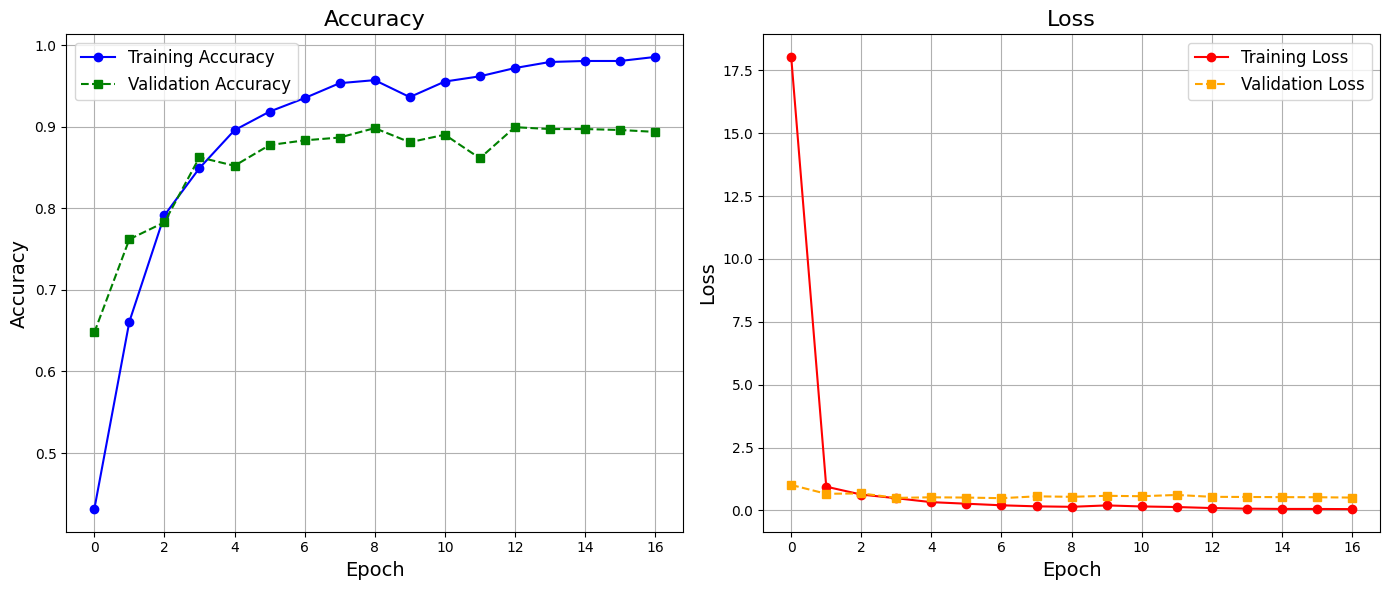

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot accuracy on the first axis
ax1.plot(history.history['accuracy'], label='Training Accuracy', marker='o', linestyle='-', color='blue')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s', linestyle='--', color='green')
ax1.set_title('Accuracy', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14)
ax1.grid(True)
ax1.legend(fontsize=12)

# Plot loss on the second axis
ax2.plot(history.history['loss'], label='Training Loss', marker='o', linestyle='-', color='red')
ax2.plot(history.history['val_loss'], label='Validation Loss', marker='s', linestyle='--', color='orange')
ax2.set_title('Loss', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_ylabel('Loss', fontsize=14)
ax2.grid(True)
ax2.legend(fontsize=12)

# Show both plots side by side
plt.tight_layout()
plt.show()

La imagen muestra las matrices de confusión para los conjuntos de **entrenamiento**, **validación**, y **prueba** en un problema de clasificación con cinco clases: *biotite*, *chrysocolla*, *malachite*, *pyrite*, y *quartz*.

### Observaciones clave:
1. **Entrenamiento**: El modelo tiene un rendimiento muy alto, con la mayoría de las predicciones correctas (elementos en la diagonal). Los errores de clasificación son mínimos.
2. **Validación**: Aunque el rendimiento sigue siendo bueno, se observan más errores en comparación con el conjunto de entrenamiento, especialmente en las clases *malachite* y *chrysocolla*.
3. **Prueba**: El rendimiento es similar al de validación, con algunas confusiones entre *malachite* y *chrysocolla* y ligeras confusiones en *biotite* y *pyrite*.

El modelo parece generalizar bien, pero tiene algunas confusiones en las clases mencionadas, principalmente en los conjuntos de validación y prueba.

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


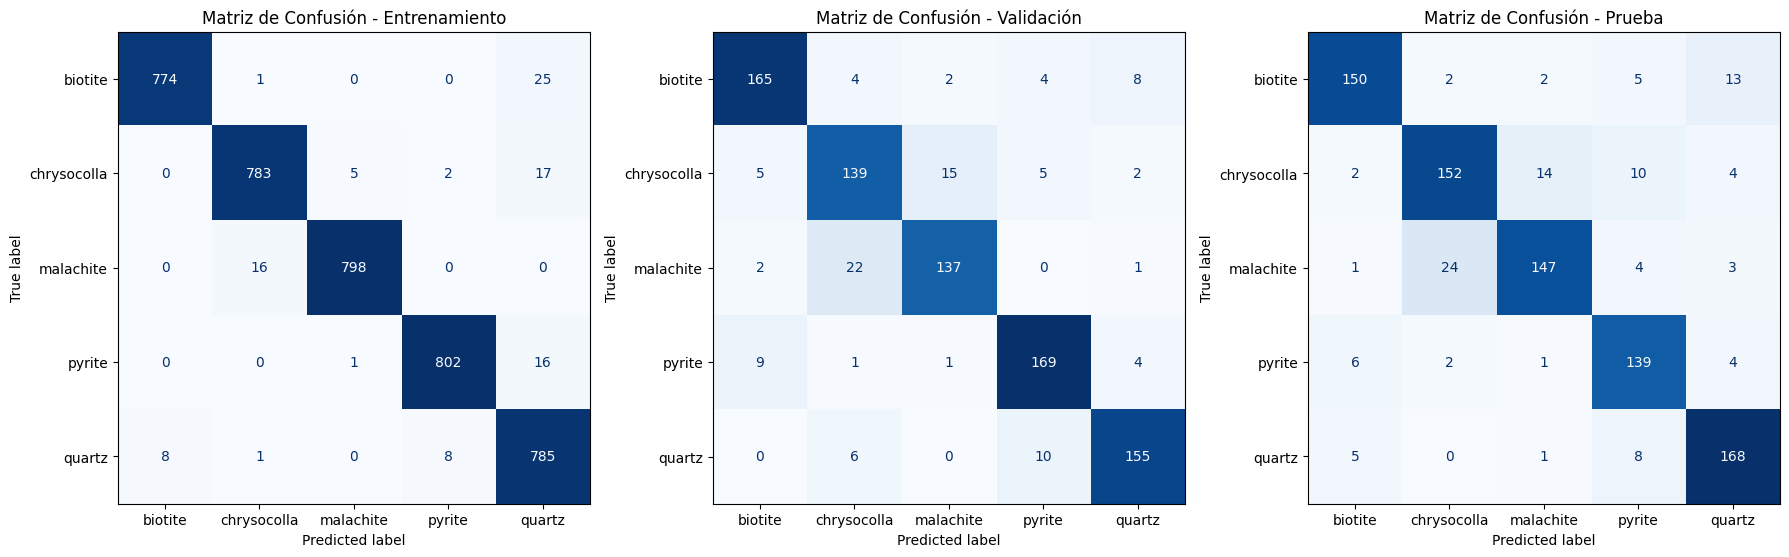

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predicciones para el conjunto de entrenamiento
y_train_pred = model.predict(X_train)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

# Predicciones para el conjunto de validación
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Predicciones para el conjunto de prueba (test)
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Generar las matrices de confusión
conf_matrix_train = confusion_matrix(y_train, y_train_pred_classes)
conf_matrix_val = confusion_matrix(y_val, y_val_pred_classes)
conf_matrix_test = confusion_matrix(y_test, y_test_pred_classes)

# Mostrar las tres matrices de confusión lado a lado
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Matriz de confusión del conjunto de entrenamiento
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train, display_labels=class_names).plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('Matriz de Confusión - Entrenamiento')

# Matriz de confusión del conjunto de validación
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_val, display_labels=class_names).plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title('Matriz de Confusión - Validación')

# Matriz de confusión del conjunto de prueba
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=class_names).plot(ax=axes[2], cmap='Blues', colorbar=False)
axes[2].set_title('Matriz de Confusión - Prueba')

# Ajustar el layout
plt.tight_layout()
plt.show()

Este es un conjunto de informes de clasificación (classification reports) que incluyen las métricas **precision**, **recall**, **f1-score** y **support** para tres conjuntos de datos: entrenamiento, validación y prueba. A continuación se describen los resultados clave:

### Entrenamiento:
- **Exactitud (accuracy)**: 0.98, lo que indica un alto rendimiento del modelo en el conjunto de entrenamiento.
- Las clases *biotite*, *malachite*, y *pyrite* tienen los valores más altos de precisión, recall y f1-score (0.98 o más), mientras que *quartz* tiene un f1-score ligeramente menor (0.95).

### Validación:
- **Exactitud (accuracy)**: 0.88, lo que sugiere que el modelo tiene un rendimiento menor en comparación con el conjunto de entrenamiento.
- La clase *chrysocolla* tiene la menor precisión (0.81) y el menor f1-score (0.82), indicando que es la clase más difícil de predecir en el conjunto de validación.

### Prueba:
- **Exactitud (accuracy)**: 0.87, lo que es consistente con el rendimiento en el conjunto de validación.
- *Chrysocolla* y *malachite* muestran valores más bajos en precisión y f1-score, mientras que *biotite* y *quartz* tienen un f1-score más alto (0.89).

### Conclusión:
El modelo muestra un buen rendimiento en el conjunto de entrenamiento (0.98 de exactitud), pero experimenta una ligera disminución de rendimiento en los conjuntos de validación y prueba (0.88 y 0.87 de exactitud, respectivamente), sugiriendo un leve sobreajuste. Las clases *chrysocolla* y *malachite* son las más difíciles de clasificar en los conjuntos de validación y prueba.

In [36]:
from sklearn.metrics import classification_report
import numpy as np

# 1. Predecir las clases para el conjunto de entrenamiento
y_train_pred = model.predict(X_train)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

# 2. Predecir las clases para el conjunto de validación
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# 3. Predecir las clases para el conjunto de prueba
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# 4. Generar el classification report para cada conjunto de datos

# Informe de clasificación para el conjunto de entrenamiento
train_report = classification_report(y_train, y_train_pred_classes, target_names=class_names)
print("Classification Report - Entrenamiento:")
print(train_report)

# Informe de clasificación para el conjunto de validación
val_report = classification_report(y_val, y_val_pred_classes, target_names=class_names)
print("Classification Report - Validación:")
print(val_report)

# Informe de clasificación para el conjunto de prueba (test)
test_report = classification_report(y_test, y_test_pred_classes, target_names=class_names)
print("Classification Report - Prueba:")
print(test_report)

127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Classification Report - Entrenamiento:
              precision    recall  f1-score   support

     biotite       0.99      0.97      0.98       800
 chrysocolla       0.98      0.97      0.97       807
   malachite       0.99      0.98      0.99       814
      pyrite       0.99      0.98      0.98       819
      quartz       0.93      0.98      0.95       802

    accuracy                           0.98      4042
   macro avg       0.98      0.98      0.98      4042
weighted avg       0.98      0.98      0.98      4042

Classification Report - Validación:
              precision    recall  f1-score   support

     biotite       0.91      0.90      0.91       183
 chrysocolla       0.81      0.84      0.82       166
   malachite       0.88      0.85      0.86       162
      pyrite       0.90      0.92      0.91       184
      quartz       0.91      0.91      0.91 

En la imagen se muestran representaciones de los **filtros** aprendidos por una red neuronal convolucional (CNN) en tres capas diferentes. Cada kernel está diseñado para detectar **patrones específicos** en las imágenes de entrada.

### Capa Convolucional 1:
- Los filtros de la primera capa aprenden a detectar **características simples** como bordes y contornos.
- Los colores en blanco y negro son una representación visual de los pesos que se le asigna la convolución entre 0 y 1 para poder encontrar las características, vemos entonces como empiezan a variar los pesos a través de la convolución según lo que va encontrando la imagen con el kernel de 3x3.

### Capa Convolucional 2:
- En esta capa, los filtros empiezan a capturar **combinaciones de características** detectadas por la primera capa, como esquinas o formas más complejas.
- Podemos ver como va cambiando los pesos para ir encontrando diferentes características en las imágenes, partes que antes eran blancas, es decir que se les asignaba numericamente un peso bajo, empiezan a tomar valores más grandes dentro de los filtros de convolución.

### Capa Convolucional 3:
- En la tercera capa, los filtros detectan **características más abstractas y complejas**, basadas en las características previamente capturadas.
- Nuevamente los colores empiezan a variar para poder ir encontrando las características en las imágenes.

### Conclusión:
Los filtros en las capas más tempranas de la CNN se enfocan en **bordes simples**, mientras que en las capas más profundas, los filtros detectan **patrones más complejos**. Podemos ver como el color es una representación más directa frente a esto, pero no debemos ignorar lo que en realidad se esta asignando en cada uno de esos filtros, los pesos para poder ir encontrando las características e irlos variando para poder mejorar la extracción de características y las predicciones.

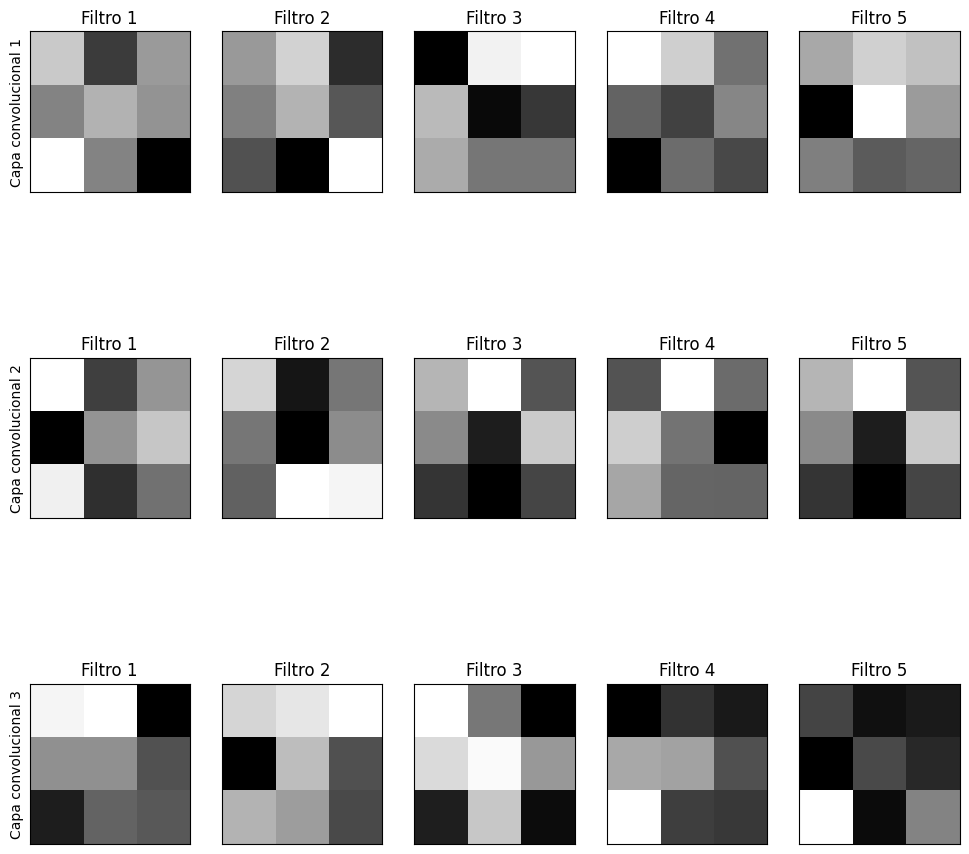

In [23]:
# Selección de las capas convolucionales del modelo
conv_layers = [layer for layer in model.layers if "conv" in layer.name]

# Configurar una semilla aleatoria para la reproducibilidad
np.random.seed(50)

# Crear subplots para visualizar los filtros de cada capa convolucional
_, axes = plt.subplots(len(conv_layers), 5, figsize=(12, 12))

# Iterar sobre cada capa convolucional
for i, layer in enumerate(conv_layers):
    # Etiquetar las capas en los gráficos
    axes[i, 0].set_ylabel(f"Capa convolucional {i+1}")

    # Obtener los pesos (filtros) y sesgos de cada capa convolucional
    filters, biases = layer.get_weights()

    # Reescalar los filtros para su visualización (normalización)
    filters = (filters - filters.min()) / (filters.max() - filters.min())

    # Seleccionar aleatoriamente 4 filtros para la gráfica
    sel = np.random.randint(0, filters.shape[-1], 5)
    filters_selected = filters[:, :, :, sel]

    # Mover el eje de los filtros seleccionados para facilitar la visualización
    filters_selected = np.moveaxis(filters_selected, -1, 0)

    # Promediar los filtros en los canales RGB para visualizar en escala de grises
    filters_selected = np.mean(filters_selected, axis=3, keepdims=True)

    # Iterar sobre los filtros seleccionados para visualizarlos
    for j, filter in enumerate(filters_selected):
        # Visualización de los filtros en escala de grises
        axes[i, j].imshow(filter, cmap="gray")
        axes[i, j].set_title(f"Filtro {j+1}")

        # Eliminar los ticks en los ejes
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

# Mostrar la visualización de los filtros
plt.show()


### Interpretación de las activaciones de la red convolucional:

#### Capa Convolucional 1:
- Podemos ver como en esta capa se atrapan características más grandes en la mayoría de la aplicación de los kernels en cada imagen, lo cual tiene sentido ya que al ser la primera capa es donde apenas está ocurriendo el aprendizaje, vemos como la imagen 3 trata de captar características más puntuales pero luego vuelve a las partes más notables en la imagen. No hay una búsqueda de rasgos puntuales como bordes o textura sino más generales dentro de la imagen.

#### Capa Convolucional 2:
- Es donde se empiezan a buscar características más puntuales, empezando con un kernel que busca rasgos grandes, pero luego podemos ir viendo como empieza a buscar rasgos puntuales en la imagen, centrandose más en los bordes principalmente, vemos como empieza a osucrecer la imagen y ver que partes empiezan a resaltar.

#### Capa Convolucional 3:
- En la tercera fila, las activaciones son más localizadas y específicas. En todas las imágenes, se observan pequeñas áreas activadas, lo que indica que la red está enfocándose en detalles que el ojo humano puede pasar desapercibido de la imagen.
- Estas activaciones sugieren que la red ha aprendido a concentrarse en partes muy específicas de la imagen, identificando patrones abstractos importantes para la clasificación.

Este comportamiento es típico en redes convolucionales, donde las primeras capas detectan características simples y las capas más profundas capturan características más abstractas y detalladas.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


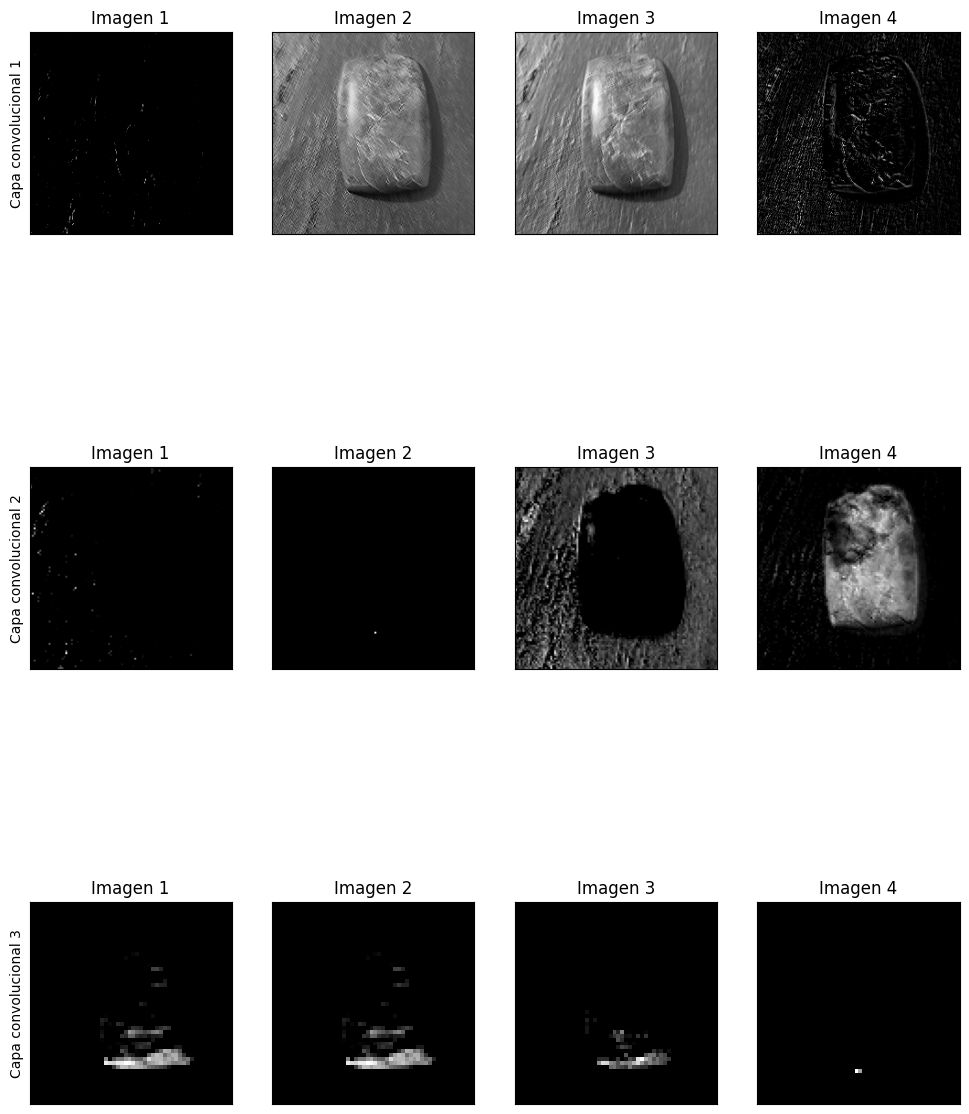

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Crear una figura para los subplots
_, axes = plt.subplots(len(conv_layers), 4, figsize=(12, 16))

# Establecer una semilla para obtener resultados reproducibles
np.random.seed(50)

# Crear un modelo intermedio para obtener la salida de cada capa convolucional
vis_model = tf.keras.models.Model(
    inputs=model.inputs,
    outputs=[layer.output for layer in conv_layers]
)

# Aplicar el modelo para obtener el mapa de características de la muestra X_test[33]
feature_maps = vis_model.predict(np.expand_dims(X_test[13], axis=0))

# Iterar sobre cada capa convolucional y sus respectivos mapas de características
for i, f_map in enumerate(feature_maps):
    axes[i, 0].set_ylabel(f"Capa convolucional {i+1}")

    # Filtrar los mapas de características donde haya activación (donde los valores son mayores a 0)
    f_map = f_map[:, :, :, np.any(f_map[0, :, :, :] > 0, axis=(0, 1))]

    # Seleccionar aleatoriamente 4 mapas de características para visualizar
    sel = np.random.randint(0, f_map.shape[-1], 4)
    feature_map_selected = f_map[:, :, :, sel]
    feature_map_selected = feature_map_selected[0]  # Seleccionar el primer mapa de características
    feature_map_selected = np.moveaxis(feature_map_selected, -1, 0)  # Mover el eje para facilitar la visualización

    # Iterar sobre las imágenes seleccionadas y mostrarlas
    for j, image in enumerate(feature_map_selected):
        # Visualizar cada mapa de características en escala de grises
        axes[i, j].imshow(image, cmap="gray")
        axes[i, j].set_title(f"Imagen {j+1}")

        # Eliminar los ticks de los ejes
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

# Mostrar el gráfico con los mapas de características
plt.show()


# Transfering Learning

In [25]:
base_model = EfficientNetB1(input_shape = (s, s, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = True

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [26]:
KerasModel = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation="relu"),
    Dropout(0.5),
    Dense(1024, activation="relu"),
    Dropout(0.5),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

In [27]:
opt = keras.optimizers.Adam(learning_rate=0.000025)
KerasModel.compile(optimizer = opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [28]:
print('Model Details are : ')

KerasModel.build(input_shape=(None, 224, 224, 3))
KerasModel.summary()

Model Details are : 


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb1 (Functional)          │ (None, 7, 7, 1280)          │       6,575,239 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,594,510 (36.60 MB)

 Trainable params: 9,532,455 (36.36 MB)

 Non-trainable params: 62,055 (242.41 KB)

In [29]:
epochs = 40
ThisModel = KerasModel.fit(X_train,y_train, batch_size=32, epochs=epochs, validation_data=(X_val,y_val), verbose=1)

Epoch 1/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 238s 907ms/step - accuracy: 0.1643 - loss: 1.9808 - val_accuracy: 0.3383 - val_loss: 1.7282
Epoch 2/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 23s 184ms/step - accuracy: 0.2206 - loss: 1.7827 - val_accuracy: 0.5069 - val_loss: 1.6450
Epoch 3/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 184ms/step - accuracy: 0.2491 - loss: 1.6968 - val_accuracy: 0.5808 - val_loss: 1.5684
Epoch 4/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.2980 - loss: 1.6136 - val_accuracy: 0.6767 - val_loss: 1.4563
Epoch 5/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 23s 184ms/step - accuracy: 0.3683 - loss: 1.5143 - val_accuracy: 0.7159 - val_loss: 1.2672
Epoch 6/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - accuracy: 0.4215 - loss: 1.3983 - val_accuracy: 0.7344 - val_loss: 1.0040
Epoch 7/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 185ms/step - accuracy: 0.5344 - loss: 1.1783 - val_accuracy: 0.7898 - val_loss: 0.7570
Epoch 8/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.6323 - loss: 

# Accuracy of model

In [30]:
ModelLoss, ModelAccuracy = KerasModel.evaluate(X_test, y_test)

print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 298ms/step - accuracy: 0.9800 - loss: 0.1126
Test Loss is 0.1265500783920288
Test Accuracy is 0.9746251702308655


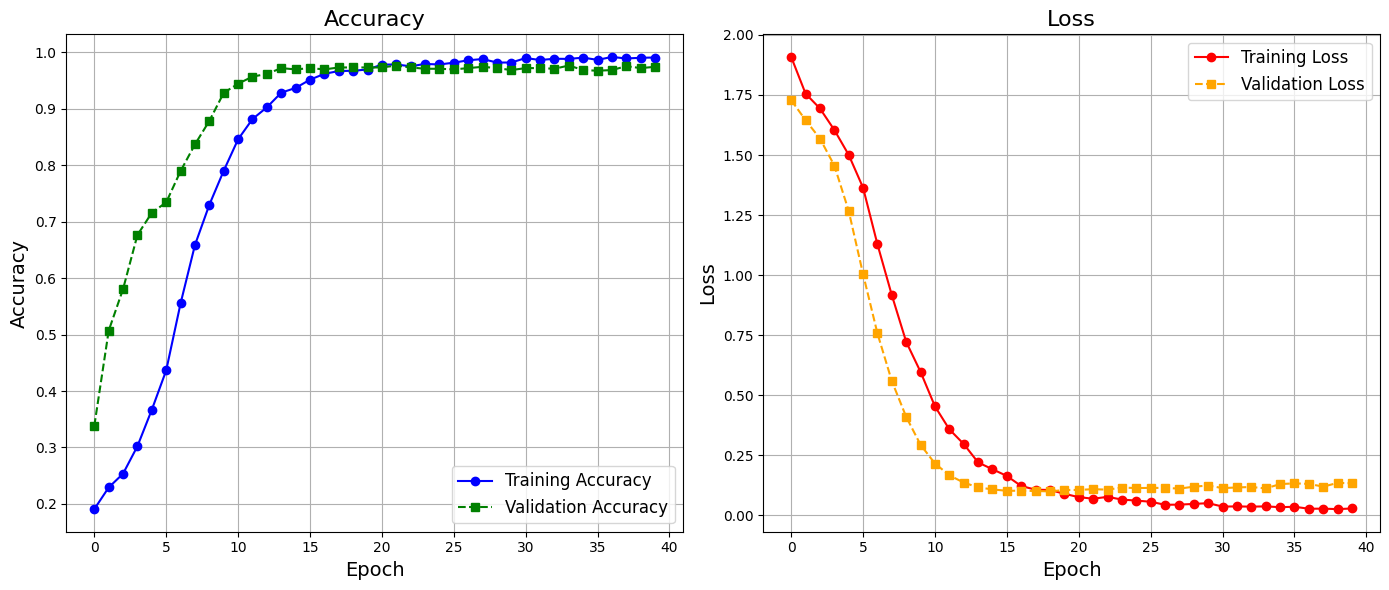

In [31]:
# summarize model for accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot accuracy on the first axis
ax1.plot(ThisModel.history['accuracy'], label='Training Accuracy', marker='o', linestyle='-', color='blue')
ax1.plot(ThisModel.history['val_accuracy'], label='Validation Accuracy', marker='s', linestyle='--', color='green')
ax1.set_title('Accuracy', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14)
ax1.grid(True)
ax1.legend(fontsize=12)

# Plot loss on the second axis
ax2.plot(ThisModel.history['loss'], label='Training Loss', marker='o', linestyle='-', color='red')
ax2.plot(ThisModel.history['val_loss'], label='Validation Loss', marker='s', linestyle='--', color='orange')
ax2.set_title('Loss', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_ylabel('Loss', fontsize=14)
ax2.grid(True)
ax2.legend(fontsize=12)

# Show both plots side by side
plt.tight_layout()
plt.show()

In [41]:
y_train_pred = KerasModel.predict(X_train).argmax(axis=1)
y_val_pred = KerasModel.predict(X_val).argmax(axis=1)
y_test_pred = KerasModel.predict(X_test).argmax(axis=1)

127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


La imagen muestra las matrices de confusión para los conjuntos de **entrenamiento**, **validación**, y **prueba** en un problema de clasificación con cinco clases: *biotite*, *chrysocolla*, *malachite*, *pyrite*, y *quartz*.

1. **Entrenamiento**:
   - El modelo muestra un rendimiento excelente, con predicciones prácticamente perfectas. Las clases son clasificadas correctamente, con solo algunos errores mínimos en la clase *quartz*.
   
2. **Validación**:
   - El rendimiento sigue siendo alto, pero aparecen algunos errores. Hay confusiones entre las clases *malachite* y *chrysocolla*, así como entre *pyrite* y *quartz*. A pesar de estos errores, el modelo se comporta bastante bien con la mayoría de las predicciones correctas.

3. **Prueba**:
   - El comportamiento es similar al de la validación. La clase *chrysocolla* tiene algunos errores, ya que se confunde con *malachite*. Otras confusiones menores ocurren entre *pyrite* y *quartz*.
   
En general, el modelo tiene un rendimiento sólido en los tres conjuntos, pero las clases *malachite*, *chrysocolla* y *pyrite* presentan algunas confusiones en los conjuntos de validación y prueba.


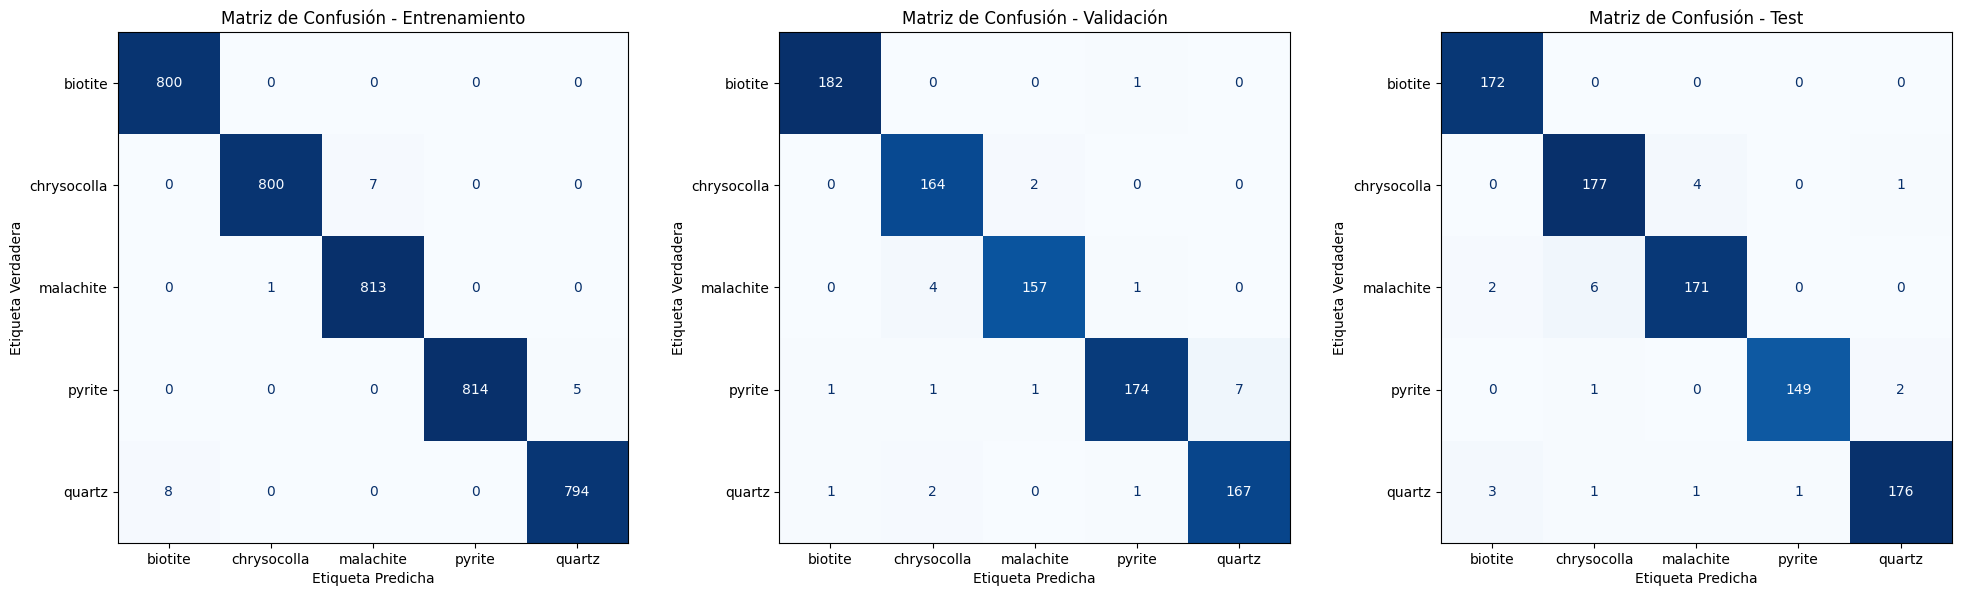

In [47]:
CM_train = confusion_matrix(y_train, y_train_pred)
CM_val = confusion_matrix(y_val, y_val_pred)
CM_test = confusion_matrix(y_test, y_test_pred)

# Crear la figura y los tres subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Matriz de confusión para el conjunto de entrenamiento
ConfusionMatrixDisplay(confusion_matrix=CM_train, display_labels=class_names).plot(ax=ax1, cmap='Blues', colorbar=False)
ax1.set_title('Matriz de Confusión - Entrenamiento')
ax1.set_ylabel('Etiqueta Verdadera')
ax1.set_xlabel('Etiqueta Predicha')

# Matriz de confusión para el conjunto de validación
ConfusionMatrixDisplay(confusion_matrix=CM_val, display_labels=class_names).plot(ax=ax2, cmap='Blues', colorbar=False)
ax2.set_title('Matriz de Confusión - Validación')
ax2.set_ylabel('Etiqueta Verdadera')
ax2.set_xlabel('Etiqueta Predicha')

# Matriz de confusión para el conjunto de test
ConfusionMatrixDisplay(confusion_matrix=CM_test, display_labels=class_names).plot(ax=ax3, cmap='Blues', colorbar=False)
ax3.set_title('Matriz de Confusión - Test')
ax3.set_ylabel('Etiqueta Verdadera')
ax3.set_xlabel('Etiqueta Predicha')

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()
plt.show()

Este es un conjunto de informes de clasificación (classification reports) que incluyen las métricas **precision**, **recall**, **f1-score** y **support** para tres conjuntos de datos: entrenamiento, validación y prueba. A continuación se describen los resultados clave:

### Entrenamiento:
- **Exactitud (accuracy)**: 0.99, indicando un rendimiento casi perfecto en el conjunto de entrenamiento.
- Todas las clases tienen valores altos de precisión, recall y f1-score (0.99 o más), con un desempeño excepcional en todas las clases.

### Validación:
- **Exactitud (accuracy)**: 0.97, mostrando un buen rendimiento, aunque ligeramente inferior al del conjunto de entrenamiento.
- Las clases *biotite* y *quartz* tienen un f1-score muy alto (0.99 y 0.98 respectivamente), mientras que las otras clases también muestran un rendimiento muy sólido con f1-scores cercanos a 0.97.

### Prueba:
- **Exactitud (accuracy)**: 0.97, consistente con el rendimiento en validación.
- *Chrysocolla* y *malachite* muestran valores ligeramente más bajos en comparación con otras clases, pero siguen siendo altos (f1-scores de 0.97). *Quartz* y *pyrite* tienen f1-scores de 0.97 y 0.96 respectivamente.


In [35]:
y_train_pred = KerasModel.predict(X_train)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

y_val_pred = KerasModel.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

y_test_pred = KerasModel.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)


train_report = classification_report(y_train, y_train_pred_classes, target_names=class_names)
print("Classification Report - Entrenamiento:")
print(train_report)

# Informe de clasificación para el conjunto de validación
val_report = classification_report(y_val, y_val_pred_classes, target_names=class_names)
print("Classification Report - Validación:")
print(val_report)

# Informe de clasificación para el conjunto de prueba (test)
test_report = classification_report(y_test, y_test_pred_classes, target_names=class_names)
print("Classification Report - Prueba:")
print(test_report)

127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Classification Report - Entrenamiento:
              precision    recall  f1-score   support

     biotite       0.99      1.00      1.00       800
 chrysocolla       1.00      0.99      1.00       807
   malachite       0.99      1.00      1.00       814
      pyrite       1.00      0.99      1.00       819
      quartz       0.99      0.99      0.99       802

    accuracy                           0.99      4042
   macro avg       0.99      0.99      0.99      4042
weighted avg       0.99      0.99      0.99      4042

Classification Report - Validación:
              precision    recall  f1-score   support

     biotite       0.99      0.99      0.99       183
 chrysocolla       0.96      0.99      0.97       166
   malachite       0.98      0.97      0.98       162
      pyrite       0.98      0.95      0.96       184
      quartz       0.96      0.98      0.97

## Conclusión


Al comparar los resultados de la red pre entrenada con la entrenada podemos encontrar en ambos casos buenos resultados, sin embargo, con el pre entrenado si se alcanzan unos valores de métricas más altos, sin embargo, el entrenamiento en nuestro caso fue más lento que al compararlo con la arquitectura propia y el uso de callbacks en intentos anteriores fue problemático ya que el aprendizaje era muy lineal por lo que detenerlo antes hacía que las métricas alcanzaron muy malos resultados, por lo que en términos de tiempo y computacionalmente es más costoso, además de que no prestan la misma flexibilidad que tener una arquitectura propia que permite un mayor aprendizaje, sin embargo, en casos donde es díficil conseguir un buen aprendizaje desde 0 y la flexibilidad no es suficiente para llegar a buenos resultados, estos modelos son altamente recomendados, en entornos donde el tiempo y la memoria son un limitante pueden no llegar a ser viables.

Alternativas como la que presta google Colab con el uso de una GPU de forma gratuita permite cerrar estas brechas y permitir aprovechar de mejor manera estas redes pre entrenadas. También la variedad que hay de estos modelos hacen que tengan una gran variedad de aplicaciones y que se pueden usar en diferentes aplicaciones, no solo en reconocimiento de imágenes, sino en reconocimiento por vídeo, o procesamiento de lenguaje natural que son tareas usualmente computacionalemente pesadas.

